credits to: https://www.kaggle.com/code/titericz/better-xgb-baseline

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv


In [2]:
test_df = pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv")
train_df =  pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv")
census_starter_df =  pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv")

In [3]:
# merge data into one raw_data dataframe
# keep a indicator to retrieve test set
test_df["is_test"] = 1
train_df["is_test"] = 0
raw_data = pd.concat([test_df, train_df]).sort_values(["cfips", "row_id"]).reset_index(drop = True)
print(raw_data.shape)
raw_data

(147345, 8)


,row_id,cfips,first_day_of_month,is_test,county,state,microbusiness_density,active
0,1001_2019-08-01,1001,2019-08-01,0,Autauga County,Alabama,3.007682,1249.0
1,1001_2019-09-01,1001,2019-09-01,0,Autauga County,Alabama,2.884870,1198.0
2,1001_2019-10-01,1001,2019-10-01,0,Autauga County,Alabama,3.055843,1269.0
3,1001_2019-11-01,1001,2019-11-01,0,Autauga County,Alabama,2.993233,1243.0
4,1001_2019-12-01,1001,2019-12-01,0,Autauga County,Alabama,2.993233,1243.0
...,...,...,...,...,...,...,...,...
147340,56045_2023-02-01,56045,2023-02-01,1,NaN,NaN,NaN,NaN
147341,56045_2023-03-01,56045,2023-03-01,1,NaN,NaN,NaN,NaN
147342,56045_2023-04-01,56045,2023-04-01,1,NaN,NaN,NaN,NaN
147343,56045_2023-05-01,56045,2023-05-01,1,NaN,NaN,NaN,NaN


In [4]:
# clean up data for county, state, prepare for date time extraction
raw_data["county"] = raw_data.groupby("cfips")["county"].ffill()
raw_data["state"] = raw_data.groupby("cfips")["state"].ffill()
raw_data["first_day_of_month"] = pd.to_datetime(raw_data["first_day_of_month"])
raw_data["year"] = raw_data["first_day_of_month"].dt.year
raw_data["month"] = raw_data["first_day_of_month"].dt.month
raw_data["county_index"] = raw_data["county"].factorize()[0]
raw_data["state_index"] = raw_data["state"].factorize()[0]
raw_data["cummulative_count"] = raw_data.groupby("cfips")["row_id"].cumcount()
raw_data

,row_id,cfips,first_day_of_month,is_test,county,state,microbusiness_density,active,year,month,county_index,state_index,cummulative_count
0,1001_2019-08-01,1001,2019-08-01,0,Autauga County,Alabama,3.007682,1249.0,2019,8,0,0,0
1,1001_2019-09-01,1001,2019-09-01,0,Autauga County,Alabama,2.884870,1198.0,2019,9,0,0,1
2,1001_2019-10-01,1001,2019-10-01,0,Autauga County,Alabama,3.055843,1269.0,2019,10,0,0,2
3,1001_2019-11-01,1001,2019-11-01,0,Autauga County,Alabama,2.993233,1243.0,2019,11,0,0,3
4,1001_2019-12-01,1001,2019-12-01,0,Autauga County,Alabama,2.993233,1243.0,2019,12,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147340,56045_2023-02-01,56045,2023-02-01,1,Weston County,Wyoming,NaN,NaN,2023,2,1870,50,42
147341,56045_2023-03-01,56045,2023-03-01,1,Weston County,Wyoming,NaN,NaN,2023,3,1870,50,43
147342,56045_2023-04-01,56045,2023-04-01,1,Weston County,Wyoming,NaN,NaN,2023,4,1870,50,44
147343,56045_2023-05-01,56045,2023-05-01,1,Weston County,Wyoming,NaN,NaN,2023,5,1870,50,45


<AxesSubplot:xlabel='cummulative_count'>

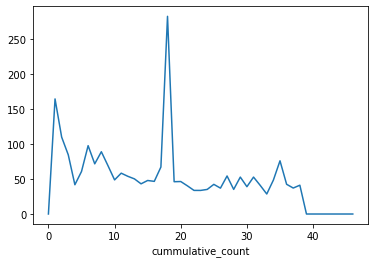

In [5]:
# checks the change in general for each time step
# high values indicate either many counties have this time step or the values at this time step have a large variance
lag = 1
raw_data[f"mb_d_lag_{lag}"] = raw_data.groupby("cfips")["microbusiness_density"].shift(lag).bfill()
raw_data["lag_ratio"] = (raw_data["microbusiness_density"] / raw_data[f"mb_d_lag_{lag}"]).fillna(1).clip(0, None) - 1
empty_entries_mask = raw_data[f"mb_d_lag_{lag}"] == 0
first_entries_mask = (raw_data[f"mb_d_lag_{lag}"] == 0) & (raw_data["microbusiness_density"] > 0)
raw_data.loc[empty_entries_mask, "lag_ratio"] = 0
raw_data.loc[first_entries_mask, "lag_ratio"] = 1
raw_data["lag_ratio"] = raw_data["lag_ratio"].abs()
raw_data.groupby("cummulative_count")["lag_ratio"].sum().plot()

In [6]:
# smooth outliers
outliers = set()
outliers_count = 0
for c in raw_data["cfips"].unique():
    c_mask = raw_data["cfips"] == c
    specific_cfips_df = raw_data[c_mask].copy().reset_index(drop = True)
    mb_d_values = specific_cfips_df["microbusiness_density"].values.copy()
    n = len(mb_d_values)
    for i in range(n - 1, 2, -1):
        tau = 0.2 * np.mean(mb_d_values[:i])
        abs_diff = abs(mb_d_values[i] - mb_d_values[i - 1])
        if abs_diff > tau and mb_d_values[i - 1] > 0:
            mb_d_values[:i] *= mb_d_values[i] / mb_d_values[i - 1]
            outliers.add(c)
            outliers_count += 1
    raw_data.loc[c_mask, "microbusiness_density_smoothed"] = mb_d_values

print("number of cfips that have outliers: ", len(outliers))
print("number of values smoothed: ", outliers_count)

number of cfips that have outliers:  485
number of values smoothed:  741


<AxesSubplot:xlabel='cummulative_count'>

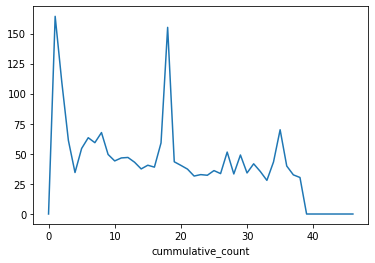

In [7]:
# show smoothing
lag = 1
raw_data[f"mb_d_smooth_lag_{lag}"] = raw_data.groupby("cfips")["microbusiness_density_smoothed"].shift(lag).bfill()
raw_data["smooth_lag_ratio"] = (raw_data["microbusiness_density_smoothed"] / raw_data[f"mb_d_smooth_lag_{lag}"]).fillna(1).clip(0, None) - 1
empty_entries_mask = raw_data[f"mb_d_smooth_lag_{lag}"] == 0
first_entries_mask = (raw_data[f"mb_d_smooth_lag_{lag}"] == 0) & (raw_data["microbusiness_density_smoothed"] > 0)
raw_data.loc[empty_entries_mask, "smooth_lag_ratio"] = 0
raw_data.loc[first_entries_mask, "smooth_lag_ratio"] = 1
raw_data["smooth_lag_ratio"] = raw_data["smooth_lag_ratio"].abs()
raw_data.groupby("cummulative_count")["smooth_lag_ratio"].sum().plot()

In [8]:
# python widget to display density based on cfips
@interact(chosen_cfips = widgets.Dropdown(
    options = raw_data["cfips"].unique(),
    value = 1001,
    description = "CFIPS",
    disabled = False
))
def show_data(chosen_cfips):
    raw_data.loc[raw_data["cfips"] == chosen_cfips].plot(x = "cummulative_count", y = "microbusiness_density_smoothed")

interactive(children=(Dropdown(description='CFIPS', options=(1001, 1003, 1005, 1007, 1009, 1011, 1013, 1015, 1…

In [9]:
# check if any area has no past data history
cfips = list(raw_data["cfips"].unique())
all_zeros = []
for c in cfips:
    c_mask = raw_data["cfips"] == c
    specific_cfips_df = raw_data[c_mask]
    mb_d_smoothed_values = specific_cfips_df["microbusiness_density_smoothed"].values.copy()
    if all([not (v > 0) for v in mb_d_smoothed_values]): all_zeros.append(c)
all_zeros

[28055]

In [10]:
# create target variable
# shift all predictions backwards by 1
raw_data["target"] = raw_data.groupby("cfips")["microbusiness_density_smoothed"].shift(-1)
# obtain (percentage) change
raw_data["target"] = raw_data["target"] / raw_data["microbusiness_density_smoothed"] - 1

# for all_zeros, since all values were 0, set to 0 first
for c in all_zeros:
    raw_data.loc[raw_data["cfips"] == c, "target"] = 0.0

In [11]:
@interact(bins = widgets.IntSlider(
    value = 10,
    min = 10,
    max = 150,
    disabled = False
))
def printHist(bins):
    raw_data["target"].clip(-0.05, 0.05).hist(bins = bins)

interactive(children=(IntSlider(value=10, description='bins', max=150, min=10), Output()), _dom_classes=('widg…

Learning Points

time series terminology
- levels: similar to points, some can be significant (turning points, gradient increases / decreases)
- trend: gradient, is a vector, has magnitude (rate of change of level) and direction (positive / negative)
- seasonality: periodic up and down trends

smoothing outliers for time series prediction
- to identify changes within noisy data
- moving average smoothing
    - derived as the average of the last k elements in the time series
    - weights each observation equally
    - in general, small k leads to larger variation, large k leads to more smoothing (considered more data points in the average)
y_i = sum([y_j for j in range(i - k, i)])
- exponential smoothing
    - same idea, except exponentially decreasing weights are assigned to data that is further back from the present
y_i = a * y_i + (1 - a) * y_(i - 1), i > 0, 0 < a < 1
- double exponential smoothing
    - exponential smoothing might not be suitable for trends
    - constant a is used for smoothing the level, constant b is used for smoothing the trend
L_0 = y_0, B_0 = y_1 - y_0
overall equation: y_(i + h) = L_i + h * B_i
level equation: L_i = a * y_i + (1 - a) * (L_(i - 1) + B_(i - 1))
trend equation: B_i = b * (L_i - L_(i - 1)) + (1 - b) * B_(i - 1)
a, b in (0, 1)
- triple exponential smoothing (Holt-Winters Exponential Smoothing)
    - smooth seasonality
    - can be either additive or multiplicative
additive: S_i = 
overall equation: y_(i + h) = L_i + h * B_i + s_(i + h - m)
level equation: L_i = a * (y_i - s_(i - m)) + (1 - a) * (L_(i - 1) + B_(i - 1))
trend equation: B_i = b * (S_i - S_(i - 1)) + (1 - b) * B_(i - 1)
seasonality equation: s_i = gamma * (y_i - L_(i - 1) - B_(i - 1)) + (1 - gamma) * s_(i - m)

sources:
https://medium.com/@srv96/smoothing-techniques-for-time-series-data-91cccfd008a2
https://towardsdatascience.com/time-series-forecasting-with-holt-winters-b78ffc322f24

SMAPE
- Symmetric Mean Absolute Percentage Error
SMAPE = (100% / n) * sum([abs(F_i - A_i) / ((abs(F_i) + abs(A_i)) / 2) for i in range(n])
- where F_i is the forecasted value at timestep i, and A_i is the actual value of the timestep i
- Range is from 0 - 200%, but sometimes easier to interpret range from 0% - 100%
- use SMAPE formula without division of 2 in denominator
SMAPE = (100% / n) * sum([abs(F_i - A_i) / (abs(F_i) + abs(A_i)) for i in range(n])
- note that over- and under- assumptions are treated different
- e.g. A = 100, F1 = 90, F2 = 110, so abs(A - F1) == abs(A - F2)
- SMAPE_F1 = (abs(100 - 90) / (abs(100) + abs(90))) * 100% = 5.2%
- SMAPE_F2 = (abs(100 - 110) / (abs(100) + abs(110))) * 100% = 4.7%
- implies underestimation may be more costly
- limitation: if (F_i = 0 and A_i != 0) or (F_i != 0 and A_i = 0), the SMAPE is immediately the upper bound
- Alternative version of SMAPE to account for direction of bias
SMAPE = (100% / n) * sum([abs(F_i - A_i) for i in range(n)]) / sum([F_i + A_i for i in range(n)])
source: https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

pandas functions
- factorize(): returns a numpy array of the corresponding codes (index 0) and a series of unique values (index 2)
- clip(lower, upper): clips the series to be bounded by the lower and upper values stated. values smaller than lower are set to lower, values larger than upper are set to upper
- shift(val): returns a series of the same values but values shifted by val. if val is positive, the shift is forward, if val is negative, the shift is backwards